In [1]:
import sys
import os
sys.path.append('../')
from tqdm.auto import tqdm
from collections import defaultdict
from functools import partial
import py3Dmol
from IPython.display import IFrame, SVG, display
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from webapp.utils import ECSiteBinInferenceAPI, get_structure_html_and_active_data, white_pdb,  reaction2svg, file_cache_path, rxn_fig_path, label2active_type


/home/xiaoruiwang/software/miniconda3/envs/py38/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
ECSitePred = ECSiteBinInferenceAPI(model_checkpoint_path='../checkpoints/enzyme_site_predition_model_finetune_with_mcsa/train_in_normal_mcsa_at_2023-10-06-09-48-04/global_step_37200')

/home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/ec_site_prediction/script/../model_structure/esm_layer.py:297: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Loading reaction attention model checkpoint from ../checkpoints/reaction_attn_net/model-ReactionMGMTurnNet_train_in_uspto_at_2023-04-05-23-46-25...
Extra layers: ['atom_attn_net.layers.0.cross_attn.relative_k', 'atom_attn_net.layers.1.cross_attn.relative_k', 'atom_attn_net.layers.2.cross_attn.relative_k', 'atom_attn_net.layers.3.cross_attn.relative_k', 'atom_attn_net.layers.4.cross_attn.relative_k', 'atom_attn_net.layers.5.cross_attn.relative_k', 'atom_attn_net.layers.6.cross_attn.relative_k', 'atom_attn_net.layers.7.cross_attn.relative_k', 'logic_atom_net.0.weight', 'logic_atom_net.0.bias', 'logic_atom_net.3.weight', 'logic_atom_net.3.bias']
Different shape layers: []
Need to train layers: []
Loaded checkpoint from ../checkpoints/enzyme_site_predition_model_finetune_with_mcsa/train_in_normal_mcsa_at_2023-10-06-09-48-04/global_step_37200


In [3]:

    

def show_structure(structure_path, 
                   structure_fname, 
                   site_labels, 
                   view_size=(450, 450), 
                   res_colors={
                    0: 'white',   # 非活性位点
                    1: 'red',     # Active Site
}):
    with open(os.path.join(structure_path, structure_fname)) as ifile:
        system = ''.join([x for x in ifile])
    
    view = py3Dmol.view(width=view_size[0], height=view_size[1])
    view.addModelsAsFrames(system)
    
    active_data = []
    
    i = 0
    for line in system.split("\n"):
        split = line.split()
        if len(split) == 0 or split[0] != "ATOM":
            continue
        res_idx = int(line[22:26].strip()) - 1
        color = res_colors[site_labels[res_idx]]
        view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
        atom_name = line[12:16].strip()
        if (atom_name == 'CA') and (site_labels[res_idx] !=0) :
            residue_name = line[17:20].strip()
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            view.addLabel(f'{residue_name} {res_idx + 1}', {"fontSize": 20, "position": {"x": x, "y": y, "z": z}, "fontColor": color, "fontOpacity":1.0 ,"backgroundColor": 'white', "backgroundOpacity": 0.0})  # 设置label从1开始
            active_data.append((res_idx + 1, residue_name, color, 'Active Site'))
        i += 1
    # view.addSurface(py3Dmol.SAS, {'opacity': 0.5})
    view.zoomTo()
    view.show()
    return active_data

def show_structures(structure_path, 
                   structure_fname, 
                   pred_site_labels,
                   view_size=(450, 450), 
                   res_colors={
                    0: '#73B1FF',   # 非活性位点
                    1: '#FF0000',     # Binding Site
                    2: 'green',     # Active Site
                    3: '#FFFF00',     # Other Site
}):
    print('#'*20 + ' Predicted Active Site ' + '#'*20)
    return show_structure(structure_path, structure_fname, pred_site_labels, view_size=view_size, res_colors=res_colors)

def inference_and_show(rxn, enzyme_structure_path):
    pred_active_labels = ECSitePred.inference(rxn, enzyme_structure_path)

    active_data = show_structures(structure_path='../dataset/ec_site_dataset/structures/alphafolddb_download',
                structure_fname=enzyme_structure_path,
                pred_site_labels=pred_active_labels, view_size=(600, 600)
                )
    
    active_data_df = pd.DataFrame(active_data, columns=['Residue Index', 'Residue Name', 'Color', 'Catalyst Active Type'])
    display(active_data_df)

def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()


In [4]:
test_dataset = pd.read_csv('../dataset/mcsa_fine_tune/normal_mcsa/test_dataset/mcsa_test.csv')

In [5]:
def get_rxn_str_from_ecreaction(ecreaction):
    substrates, products = ecreaction.split('>>')
    reactants, _ = substrates.split('|')
    return f'{reactants}>>{products}'

In [6]:
def show_one(index):
    rxn = test_dataset['rxn_smiles'].tolist()[index]
    pdb_id = test_dataset['alphafolddb-id'].tolist()[index]
    gt_site_labels = test_dataset['site_labels'].tolist()[index]
    ec_number = test_dataset['ec'].tolist()[index]
    print('EC Number:')
    print(ec_number)
    print('Reaction:')
    print(rxn)
    print('PDB Name:')
    print(pdb_id)
    print(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry')
    print('GT Site Lables:')
    print(gt_site_labels)

    display(SVG(draw_chemical_reaction(rxn)))
    enzyme_structure_path = os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')
    inference_and_show(rxn=rxn, enzyme_structure_path=enzyme_structure_path)
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry', width=1200, height=900))

def show_out_one(rxn, pdb_id):
    print('Reaction:')
    print(rxn)
    print('PDB Name:')
    print(pdb_id)
    display(SVG(draw_chemical_reaction(rxn)))
    if not os.path.exists(os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')):
        os.makedirs('./pdb_cache', exist_ok=True)
        os.system(f'wget https://alphafold.ebi.ac.uk/files/AF-{pdb_id}-F1-model_v4.pdb -O ./pdb_cache/AF-{pdb_id}-F1-model_v4.pdb' )
        enzyme_structure_path = os.path.abspath(f'./pdb_cache/AF-{pdb_id}-F1-model_v4.pdb')
    else:
        enzyme_structure_path = os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')
    
    inference_and_show(rxn=rxn, enzyme_structure_path=enzyme_structure_path)
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry', width=1200, height=900))


def show_rfdiffusion_one(uniprot_id, dataset, rfdiffusion_enzyme_path, rfdiffusion_uniprot2rfdiffusion_ec, this_index=0):
    this_uniprot_dataset = dataset.loc[dataset['alphafolddb-id']==uniprot_id]
    rxn = this_uniprot_dataset['rxn_smiles'].tolist()[0]
    
    print('Reaction:') 
    print(rxn)
    print('PDB Name:')
    print(uniprot_id)
    
    display(SVG(draw_chemical_reaction(rxn)))

    class_start = rfdiffusion_uniprot2rfdiffusion_ec[uniprot_id]
    af2_structure = [x for x in os.listdir(os.path.join(rfdiffusion_enzyme_path, 'af2')) if x.startswith(class_start)]
    rf_desigh_structure = [x for x in os.listdir(os.path.join(rfdiffusion_enzyme_path, 'rfdiffusion')) if x.startswith(class_start)]
    
    
    if not os.path.exists(os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{uniprot_id}-F1-model_v4.pdb')):
        os.makedirs('./pdb_cache', exist_ok=True)
        os.system(f'wget https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb -O ./pdb_cache/AF-{uniprot_id}-F1-model_v4.pdb' )
        enzyme_structure_path = os.path.abspath(f'./pdb_cache/AF-{uniprot_id}-F1-model_v4.pdb')
    else:
        enzyme_structure_path = os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{uniprot_id}-F1-model_v4.pdb')
    
    print('Org')
    inference_and_show(rxn=rxn, enzyme_structure_path=enzyme_structure_path)
    print('AF2')
    inference_and_show(rxn=rxn, enzyme_structure_path=os.path.join(rfdiffusion_enzyme_path, 'af2', af2_structure[this_index]))
    print('RFdiffusion')
    inference_and_show(rxn=rxn, enzyme_structure_path=os.path.join(rfdiffusion_enzyme_path, 'rfdiffusion', rf_desigh_structure[this_index]))
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{uniprot_id}/entry', width=1200, height=900))

In [7]:
mcsa_row_path = '../dataset/raw_dataset/mcsa/'
all_reformated_mcsa_data_df = pd.read_csv(os.path.join(mcsa_row_path, 'all_reformated_mcsa_data.csv'))
all_reformated_mcsa_data_df

reaction  \
0     [NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]|MKIGIFDSGVG...   
1     CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...   
2     CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...   
3     O=NO.[Cu+2].[H+]|MTEQLQMTRRTMLAGAALAGAVAPLLHTA...   
4     CC([NH3+])C(=O)NC(C)C(=O)[O-].O|VEPSGHAADRIARL...   
...                                                 ...   
998   NCC(=O)N1CCC[C@H]1C(=O)O.O|MAAATGPSFWLGNETLKVP...   
999                                                 NaN   
1000  [NH3+][C@@H](CC(=O)[O-])C(=O)[O-]|MNTDVRIEKDFL...   
1001  C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...   
1002  C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](...   

                                             rxn_smiles         ec  \
0     [NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>[NH3+][C@H...    5.1.1.3   
1     CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...    3.5.2.6   
2     CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...    1.6.5.2   
3                       O=NO.[Cu+2].[H+]>>O.[Cu+].[N]=O    1.7.2.1   
4     CC([NH3+])C(=O)NC(C)C(=O)[O-].O>>C[C@@H]([NH3+...   3.4.16.6   
...                                                 ...        ...   
998   NCC(=O)N1CCC[C@H]1C(=O)O.O>>NCC(=O)O.O=C(O)C1C...   3.4.13.9   
999                                                 NaN  2.4.1.125   
1000  [NH3+][C@@H](CC(=O)[O-])C(=O)[O-]>>O=C([O-])/C...    4.3.1.1   
1001  C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...   2.7.4.26   
1002  C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](...   2.1.1.28   

     alphafolddb-id                                        aa_sequence  \
0            P56868  MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...   
1            P62593  MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...   
2            P15559  MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...   
3            P25006  MTEQLQMTRRTMLAGAALAGAVAPLLHTAQAHAAGAAAAAGAAPVD...   
4            P08819  VEPSGHAADRIARLPGQPAVDFDMYSGYITVDEGAGRSLFYLLQEA...   
...             ...                                                ...   
998          P12955  MAAATGPSFWLGNETLKVPLALFALNRQRLCERLRKNPAVQAGSIV...   
999          P13470  MEKKVRFKLRKVKKRWVTVSVASAVVTLTSLSGSLVKADSTDDRQQ...   
1000         Q9LCC6  MNTDVRIEKDFLGEKEIPKDAYYGVQTIRATENFPITGYRIHPELI...   
1001         Q9HLX1  MMILKIGGSVITDKSAYRTARTYAIRSIVKVLSGIEDLVCVVHGGG...   
1002         P11086  MSGADRSPNAGAAPDSAPGQAAVASAYQRFEPRAYLRNNYAPPRGD...   

                                            site_labels  site_types  
0                 [[7], [8], [70], [147], [178], [180]]         NaN  
1              [[68], [71], [128], [164], [232], [235]]         NaN  
2                                 [[150], [156], [162]]         NaN  
3     [[133], [136], [138], [173], [174], [183], [18...         NaN  
4                    [[62], [158], [159], [361], [413]]         NaN  
...                                                 ...         ...  
998   [[255], [276], [287], [370], [377], [398], [41...         NaN  
999                               [[477], [515], [588]]         NaN  
1000  [[101], [140], [141], [142], [187], [188], [31...         NaN  
1001  [[5], [8], [14], [45], [50], [144], [163], [205]]         NaN  
1002                                     [[185], [219]]         NaN  

[1003 rows x 7 columns]

In [8]:
len_list = []
with open('/home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/ec_site_prediction/test_pipline/esmfold_inference_test/mcsa_fasta/all_sequence.fasta', 'w') as f:
    for seq, uniprot_id in zip(all_reformated_mcsa_data_df['aa_sequence'].tolist(), all_reformated_mcsa_data_df['alphafolddb-id'].tolist()):
        if pd.isna(seq):
            continue
        if len(seq) > 1000:
            continue
        
        f.write(f'>{uniprot_id}\n')
        f.write(f'{seq}\n')
        len_list.append(len(seq))

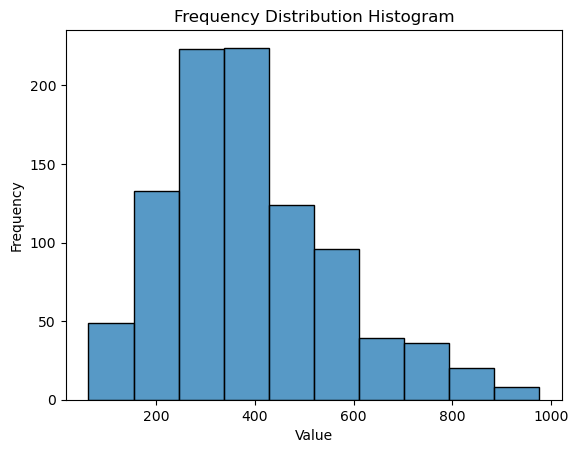

In [9]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 使用pd.cut将数据分割成5个区间
bins = pd.cut(len_list, bins=10)

# 使用pd.value_counts计算每个区间的频率
frequency = pd.value_counts(bins, sort=False)

# 使用seaborn绘制频率分布图
sns.histplot(len_list, bins=10, kde=False)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution Histogram')
plt.show()


In [10]:
len_list_df = pd.DataFrame(len_list)
len_list_df

0
0    254
1    286
2    274
3    378
4    444
..   ...
947  406
948  493
949  468
950  245
951  282

[952 rows x 1 columns]

In [11]:
len_list_df[0].max()

976

In [12]:
len_list_df[0].min()

63

In [13]:
len_list_df[0].mean()

391.47058823529414

In [14]:
(len_list_df[0] > 1000).sum()

0

In [15]:
(len_list_df[0] > 500).sum()

225

In [16]:
(len_list_df[0] > 800).sum()

28

In [17]:
rfdiffusion_data = ['O87172', 'P00655', 'P11586', 'P21164', 'P0A6L0', 'Q96C23']

'''
The selected (PDB ID, active site) for enzyme classes 1-5 were: (1a4i, Lys56-Gln100-Asp125), (1cwy, Asp293-Glu340-Asp395), (1de3, His50-Glu96-His137), (1p1x, Asp102-Lys167-Lys201), (1snz, His107-His176-Glu307).

O87172: (1cwy, Asp293-Glu340-Asp395)   EC2
P00655: (1de3, His50-Glu96-His137)     EC3
P0A6L0: (1p1x, Asp102-Lys167-Lys201)   EC4
Q96C23: (1snz, His107-His176-Glu307)   EC5


'''
rfdiffusion_uniprot2rfdiffusion_ec = {
    'O87172': 'EC2',
    'P00655': 'EC3',
    'P0A6L0': 'EC4',
    'Q96C23': 'EC5',
    
}



rfdiffusion_data_df = all_reformated_mcsa_data_df.loc[all_reformated_mcsa_data_df['alphafolddb-id'].isin(rfdiffusion_data)]
rfdiffusion_data_df['rxn_smiles'] = rfdiffusion_data_df['reaction'].apply(lambda x:get_rxn_str_from_ecreaction(x))
rfdiffusion_data_df['alphafolddb-id']= rfdiffusion_data_df['alphafolddb-id'].apply(lambda x:x.split(';')[0])
rfdiffusion_data_df

/tmp/ipykernel_2505196/1114488083.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfdiffusion_data_df['rxn_smiles'] = rfdiffusion_data_df['reaction'].apply(lambda x:get_rxn_str_from_ecreaction(x))
/tmp/ipykernel_2505196/1114488083.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfdiffusion_data_df['alphafolddb-id']= rfdiffusion_data_df['alphafolddb-id'].apply(lambda x:x.split(';')[0])


reaction  \
350  OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O|MA...   
384  Nc1nc2c(c(=O)[nH]1)N[C@@H](CNc1ccc(C(=O)N[C@@H...   
388  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...   
456  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...   
477  OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O.OC[C@H]...   
610  CC=O.O=C[C@H](O)COP(=O)([O-])[O-]|MTDLKASSLRAL...   
829  CO[C@H]1C(O)[C@H](n2cnc3c(N)ncnc32)O[C@@H]1COP...   

                                            rxn_smiles         ec  \
350  OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O>>O...    5.1.3.3   
384  Nc1nc2c(c(=O)[nH]1)N[C@@H](CNc1ccc(C(=O)N[C@@H...    6.3.4.3   
388  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...    1.5.1.5   
456  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...    3.5.4.9   
477  OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O.OC[C@H]...   2.4.1.25   
610  CC=O.O=C[C@H](O)COP(=O)([O-])[O-]>>O=CC[C@H](O...    4.1.2.4   
829  CO[C@H]1C(O)[C@H](n2cnc3c(N)ncnc32)O[C@@H]1COP...  3.1.27.10   

    alphafolddb-id                                        aa_sequence  \
350         Q96C23  MASVTRAVFGELPSGGGTVEKFQLQSDLLRVDIISWGCTITALEVK...   
384         P21164  MSKVPSDIEIAQAAKMKPVMELARGLGIQEDEVELYGKYKAKISLD...   
388         P11586  MAPAEILNGKEISAQIRARLKNQVTQLKEQVPGFTPRLAILQVGNR...   
456         P11586  MAPAEILNGKEISAQIRARLKNQVTQLKEQVPGFTPRLAILQVGNR...   
477         O87172  MELPRAFGLLLHPTSLPGPYGVGVLGREARDFLRFLKEAGGRYWQV...   
610         P0A6L0  MTDLKASSLRALKLMDLTTLNDDDTDEKVIALCHQAKTPVGNTAAI...   
829         P00655  MVAIKNLVLVALTAVTALAVPSPLEARAVTWTCLNDQKNPKTNKYE...   

                                           site_labels  site_types  
350                              [[107], [176], [307]]         NaN  
384  [[74], [76], [97], [108], [276], [304], [384],...         NaN  
388                               [[56], [100], [125]]         NaN  
456                                [[49], [56], [100]]         NaN  
477                              [[293], [340], [395]]         NaN  
610                              [[102], [167], [201]]         NaN  
829                               [[77], [123], [164]]         NaN

GT Site Lables:
[[107], [176], [307]]
EC number:
5.1.3.3
Reaction:
OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O>>OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O
PDB Name:
Q96C23


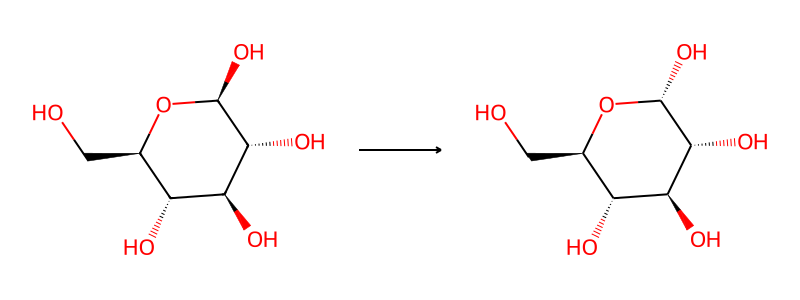

#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0             81          ASN  #FF0000          Active Site
1            107          HIS  #FF0000          Active Site
2            176          HIS  #FF0000          Active Site
3            243          ASP  #FF0000          Active Site
4            279          GLN  #FF0000          Active Site
5            307          GLU  #FF0000          Active Site

In [18]:
idx = 0
print('GT Site Lables:')
print(rfdiffusion_data_df['site_labels'].tolist()[idx])
print('EC number:')
print(rfdiffusion_data_df['ec'].tolist()[idx])
show_out_one(rfdiffusion_data_df['rxn_smiles'].tolist()[idx], rfdiffusion_data_df['alphafolddb-id'].tolist()[idx])


GT Site Lables:
[[293], [340], [395]]
EC number:
2.4.1.25
Reaction:
OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O.OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O>>OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O.OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O
PDB Name:
O87172


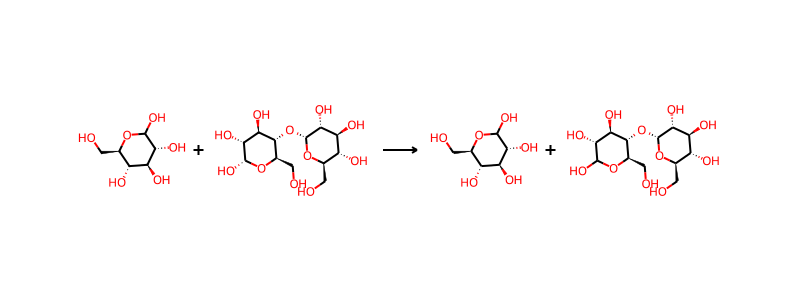

#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0             59          TYR  #FF0000          Active Site
1            291          ARG  #FF0000          Active Site
2            293          ASP  #FF0000          Active Site
3            340          GLU  #FF0000          Active Site
4            394          HIS  #FF0000          Active Site
5            395          ASP  #FF0000          Active Site

In [19]:
idx = 4
print('GT Site Lables:')
print(rfdiffusion_data_df['site_labels'].tolist()[idx])
print('EC number:')
print(rfdiffusion_data_df['ec'].tolist()[idx])
show_out_one(rfdiffusion_data_df['rxn_smiles'].tolist()[idx], rfdiffusion_data_df['alphafolddb-id'].tolist()[idx])


GT Site Lables:
[[102], [167], [201]]
EC number:
4.1.2.4
Reaction:
CC=O.O=C[C@H](O)COP(=O)([O-])[O-]>>O=CC[C@H](O)[C@H](O)COP(=O)([O-])[O-]
PDB Name:
P0A6L0


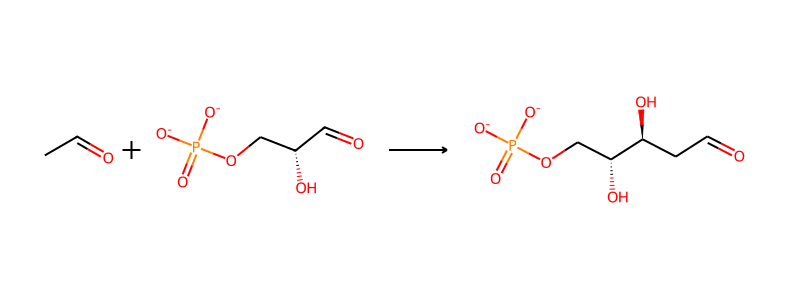

#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0            102          ASP  #FF0000          Active Site
1            167          LYS  #FF0000          Active Site
2            201          LYS  #FF0000          Active Site

In [20]:
idx = 5
print('GT Site Lables:')
print(rfdiffusion_data_df['site_labels'].tolist()[idx])
print('EC number:')
print(rfdiffusion_data_df['ec'].tolist()[idx])
show_out_one(rfdiffusion_data_df['rxn_smiles'].tolist()[idx], rfdiffusion_data_df['alphafolddb-id'].tolist()[idx])

GT Site Lables:
[[77], [123], [164]]
EC number:
3.1.27.10
Reaction:
CO[C@H]1C(O)[C@H](n2cnc3c(N)ncnc32)O[C@@H]1COP(=O)(O)O[C@H]1C(O)[C@H](n2cnc3c(=O)[nH]c(N)nc32)O[C@@H]1COP(=O)(O)OC.O>>CO[C@H]1[C@@H](O)[C@H](n2cnc3c(N)ncnc32)O[C@@H]1COP(=O)([O-])O.CP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(=O)[nH]c(N)nc32)[C@H](O)[C@@H]1O.[H+]
PDB Name:
P00655


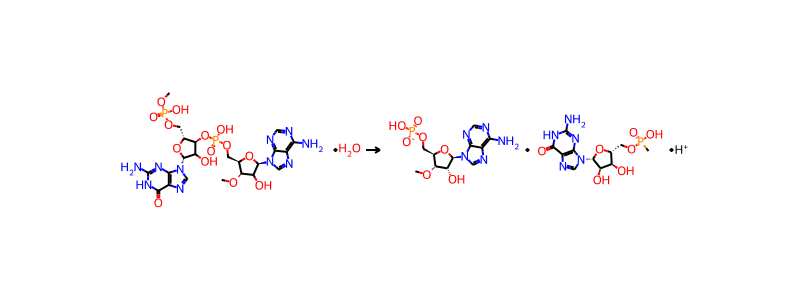

--2023-10-19 15:28:07--  https://alphafold.ebi.ac.uk/files/AF-P00655-F1-model_v4.pdb
Resolving alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)... 34.149.152.8
Connecting to alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)|34.149.152.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘./pdb_cache/AF-P00655-F1-model_v4.pdb’

     0K .......... .......... .......... .......... .......... 80.2K
    50K .......... .......... .......... .......... ..........  134K
   100K .......... .....                                        532K=1.0s

2023-10-19 15:28:09 (112 KB/s) - ‘./pdb_cache/AF-P00655-F1-model_v4.pdb’ saved [117854]



#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0             77          HIS  #FF0000          Active Site
1            123          GLU  #FF0000          Active Site
2            148          ARG  #FF0000          Active Site
3            164          HIS  #FF0000          Active Site

In [21]:
idx = 6
print('GT Site Lables:')
print(rfdiffusion_data_df['site_labels'].tolist()[idx])
print('EC number:')
print(rfdiffusion_data_df['ec'].tolist()[idx])
show_out_one(rfdiffusion_data_df['rxn_smiles'].tolist()[idx], rfdiffusion_data_df['alphafolddb-id'].tolist()[idx])


In [22]:
print(rfdiffusion_uniprot2rfdiffusion_ec)

{'O87172': 'EC2', 'P00655': 'EC3', 'P0A6L0': 'EC4', 'Q96C23': 'EC5'}


Reaction:
CC=O.O=C[C@H](O)COP(=O)([O-])[O-]>>O=CC[C@H](O)[C@H](O)COP(=O)([O-])[O-]
PDB Name:
P0A6L0


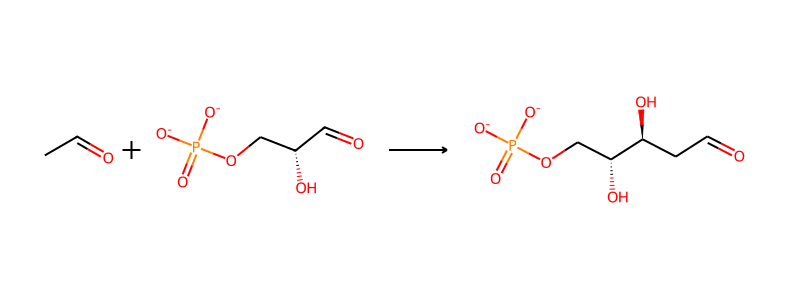

Org
#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0            102          ASP  #FF0000          Active Site
1            167          LYS  #FF0000          Active Site
2            201          LYS  #FF0000          Active Site

AF2
#################### Predicted Active Site ####################


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Residue Index Residue Name    Color Catalyst Active Type
0             66          GLU  #FF0000          Active Site

RFdiffusion


ValueError: RDKit cannot read PDB file `/home/xiaoruiwang/data/ubuntu_work_beta/protein_work/rfdiffusion_nature/PUBLIC_RELEASE/insilico_tested/Enzyme_active_site_scaffolds/rfdiffusion/EC4_design_6.pdb`

In [23]:
rfdiffusion_enzyme_path = '/home/xiaoruiwang/data/ubuntu_work_beta/protein_work/rfdiffusion_nature/PUBLIC_RELEASE/insilico_tested/Enzyme_active_site_scaffolds'

'''
The selected (PDB ID, active site) for enzyme classes 1-5 were: (1a4i, Lys56-Gln100-Asp125), (1cwy, Asp293-Glu340-Asp395), (1de3, His50-Glu96-His137), (1p1x, Asp102-Lys167-Lys201), (1snz, His107-His176-Glu307).

O87172: (1cwy, Asp293-Glu340-Asp395)   EC2
P00655: (1de3, His50-Glu96-His137)     EC3
P0A6L0: (1p1x, Asp102-Lys167-Lys201)   EC4
Q96C23: (1snz, His107-His176-Glu307)   EC5


'''

show_rfdiffusion_one('P0A6L0', dataset=rfdiffusion_data_df, rfdiffusion_enzyme_path=rfdiffusion_enzyme_path, rfdiffusion_uniprot2rfdiffusion_ec=rfdiffusion_uniprot2rfdiffusion_ec, this_index=5)

